# Jane's notes on trying the astropy module spectools.  Dec 2020. 

Use case is to fit emission line strengths from a synthetic spectrum made by Prospector, which has been fit by Gourav Khullar to the spectral energy distribution (SED) of the lensed galaxy SGAS 1723.  The SED is used in Florian et al. 2020 (about to be resubmitted to ApJ).

1) I tried using the spectools demo. Ran into a cryptic problem ( https://github.com/astropy/specutils/issues/739) traced back to a bad astroconda install.  Despite it being a new install, it was using python 2.7.  Had to re-install anaconda and astroconda from scratch.  3 hrs lost.  OK, now I have a good astroconda, and specutils is loading.  

In [213]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import jrr   # from https://github.com/janerigby/jrr
# Below is specutils stuff, from https://specutils.readthedocs.io/en/stable/
import specutils
from specutils.fitting import fit_generic_continuum, find_lines_derivative
from astropy import units as u
from astropy.visualization import quantity_support

In [121]:
# Load the spectrum file
def grab_Gouravs_file(filename, zz) :
    # Gourav printed out the SED horizontally (all waves, then all fnus), and weird units
    temp  = pandas.read_csv(filename, delim_whitespace=True, comment='#')
    df = temp.transpose().astype('float64')
    df.reset_index(inplace=True)
    df.columns=['wave', 'fnu_maggies']
    df['fnu'] = df['fnu_maggies']*3631. # convert from maggies to Janskies
    df['fnu_u'] = df['fnu'] * 0
    # Units are now wavelength in Angstroms and fnu in Janskies
    df.drop(columns='fnu_maggies', inplace=True)
    df2 = df.astype('float64').copy(deep=True)
    jrr.spec.convert2restframe_df(df2, zz, units='fnu', colwave='wave', colf='fnu', colf_u='fnu_u')
    return(df2)

In [122]:
quantity_support()  # for getting units on the axes 
zz_1723 = 1.3293
# Load the spectrum file into a Pandas DataFrame
df_s1723 = grab_Gouravs_file("Example_data/1723_bestfit_nov2020.txt", zz_1723)
df_s1723.loc[df_s1723['wave'].between(5000,5100)].head(2)  # Let's see a bit of this file


,wave,fnu,fnu_u,rest_wave,rest_fnu,rest_fnu_u
250,5021.15,5.925467e-07,0.0,2155.647619,2.543883e-07,0.0
251,5044.45,5.823926e-07,0.0,2165.650625,2.500290e-07,0.0


In [123]:
# Specutils won't take a dataframe.  It requires the data to be in a Spectrum1D object.  OK, let's try
s1723_spec = specutils.Spectrum1D(spectral_axis = df_s1723['wave'] * u.AA, flux=df_s1723['fnu'] * u.Unit('Jansky')) 

ValueError: Flux must be a `Quantity` object.

Sigh.  This is another case of Astropy refusing Pandas Series instead of accepting them.  
Filed a ticket https://github.com/astropy/specutils/issues/740#issuecomment-740190980
Until now, here's a kludgy workaround using pandas.Series.values to convert each Series to numpy array

In [124]:
s1723_spec = specutils.Spectrum1D(spectral_axis = df_s1723['wave'].values * u.AA, flux=df_s1723['fnu'].values * u.Unit('Jansky'), redshift=zz_1723) 

How do I get Spectrum1D to save and acccess the rest_fnu (off by (1+z) from the observed_fnu?)
Can't figure it out.  Filed yet another ticket. https://github.com/astropy/specutils/issues/741

(0.0, 1e-05)

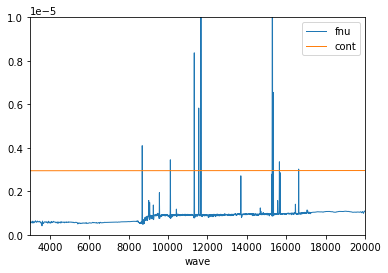

In [125]:
# Let's try to fit a continuum. The default result is terrible
ax = df_s1723.plot(x='wave', y='fnu')
cont_s1723 = fit_generic_continuum(s1723_spec, median_window=101)
df_s1723['cont'] =  cont_s1723 (df_s1723['wave'].values * u.AA )  
# Wow this is kludgy.  Why can't you attach the continuum to the Spectrum1D? Resorting to pandas.
df_s1723.plot(x='wave', y='cont', ax=ax)
plt.xlim(3000,2E4)
plt.ylim(0,1E-5)

What a terrible out-of-the-box continuum fit.  Let's figure out how to do better.

In [126]:
# Let's try auto-identifying the bright lines, and then masking them out.  This should be easy, right?
specutils.conf.do_continuum_function_check = False
rough_lines = find_lines_derivative(s1723_spec, flux_threshold=1E-6)

In [127]:
cont_s1723_v2 = fit_generic_continuum(s1723_spec, exclude_regions=rough_lines)

ValueError: The region parameter must be a SpectralRegion object.

Oh, darn it.  The output of find_lines_derivative() isn't readable by fit_continuum, and there appears to be no conversion tool. So, I don't see any built-in way to exclude features when fitting the contnuum. This part of specutils does not appear to be ready for real-world science application.

In [129]:
win = 10 # Angstroms
foos = rough_lines['line_center'][0:3]
temp = [(x - win, x + win)  for x in foos.value] # again, have to use value to stop Astropy Quantity from throwing Error
temp

[(2797.65, 2817.65), (8678.011033, 8698.011033), (9005.228311, 9025.228311)]

In [131]:
# So temp looks like a list of tuples.  Will SpectralRegion accept it?  No
from specutils.spectra import SpectralRegion
SpectralRegion((temp))

ValueError: SpectralRegion input must be a 2-tuple or a list of 2-tuples.

In [134]:
temp[0:3]

[(2797.65, 2817.65), (8678.011033, 8698.011033), (9005.228311, 9025.228311)]

Wow, that looks like a list of 2-tuples to me!  Why is temp not acceptable?

In [135]:
# This works, from the documentation for SpectralRegion.  So what's different?  Units?
[(0.45*u.um, 0.6*u.um), (0.8*u.um, 0.9*u.um)]

[(<Quantity 0.45 um>, <Quantity 0.6 um>),
 (<Quantity 0.8 um>, <Quantity 0.9 um>)]

In [136]:
# Ah! SpectralRegion secretly demands that these be Quantities, not floats, even though the docs don't say so
win = 10 # Angstroms
foos = rough_lines['line_center'][0:3]
temp = [((x - win) * u.AA, (x + win)* u.AA)  for x in foos.value] # again, have to use value to stop Astropy Quantity from throwing Error
temp

[(<Quantity 2797.65 Angstrom>, <Quantity 2817.65 Angstrom>),
 (<Quantity 8678.011033 Angstrom>, <Quantity 8698.011033 Angstrom>),
 (<Quantity 9005.228311 Angstrom>, <Quantity 9025.228311 Angstrom>)]

In [ ]:
SpectralRegion((temp))

So the error message was just plain wrong.  The problem is NOT that "SpectralRegion input must be a 2-tuple or a list of 2-tuples", but that the input was a list of 2-tuples that weren't Quantities.  This philosopy of Astropy is going to trip up folks like me who are good at Python, but don't use Astropy much

In [202]:
#Let's make an example conversion function.  Spectools needs this -- it's a common use case
def convert_lines_to_spectralregions(linelist, window=10., unit=u.AA) :
    temp =  [((x - window) * u.AA, (x + window)* u.AA)  for x in linelist['line_center'].value] # must be Quantities
    return (SpectralRegion(temp))

In [206]:
mask_emiss_lines = convert_lines_to_spectralregions(rough_lines, window=30)

In [207]:
cont_s1723_v3 = fit_generic_continuum(s1723_spec, exclude_regions=mask_emiss_lines)

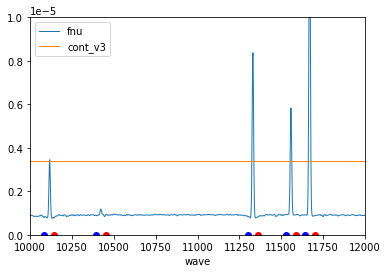

In [212]:
ax = df_s1723.plot(x='wave', y='fnu')
df_s1723['cont_v3'] =  cont_s1723_v3 (df_s1723['wave'].values * u.AA )  # Wow this is kludgy
df_s1723.plot(x='wave', y='cont_v3', ax=ax)
plt.xlim(10000,1.2E4)
plt.ylim(0,1E-5)
# SpectralRegions needs a method that marks the edges of the regions on plots.  Here's a kludgy start
for thisline in mask_emiss_lines:
    plt.plot(thisline[0].lower.value, 0.0, marker='o', color='b')
    plt.plot(thisline[0].upper.value, 0.0, marker='o', color='r')

So, I'm stuck.  I've spent a day on this.   I cannot get the default continuum-fitting to work, even after identifying emission lines and excluding them from the fit.

In [215]:
cont_s1723_v3

<QuantityModel Chebyshev1D(3, c0=0.00000337, c1=0., c2=-0., c3=0.), input_units=Angstrom, return_units=Jy>